### **Task 1: Named Entity Recognition (NER) and Feature Engineering**

### Import Python Libraries

In [1]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# Ensure all NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load spaCy model for NER
nlp = spacy.load('en_core_web_sm')

### Data Collection
Data source: https://github.com/KaiDMML/FakeNewsNet/tree/master/dataset

In [3]:
# Load dataset
files = ["/content/politifact_fake.csv", "/content/politifact_real.csv","/content/gossipcop_fake.csv", "/content/gossipcop_real.csv"]
dataframes = []

In [4]:
for file in files:
    df = pd.read_csv(file)
    df['is_fake'] = 1 if 'fake' in file else 0
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)
data.head()

,id,news_url,title,tweet_ids,is_fake
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,1
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,1
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,1
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,1
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,1


## Text Preprocessing

In [5]:
# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Normalize text
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [6]:
# Updated preprocessing function with error handling
def preprocess_text(text):
    try:
        if pd.isnull(text):
            return ""
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
        text = text.lower().strip()  # Normalize text
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_tokens)
    except LookupError as e:
        nltk.download('punkt_tab', force=True) # Download punkt_tab instead of punkt
        nltk.download('stopwords', force=True)
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_tokens)

data['cleaned_title'] = data['title'].apply(preprocess_text)
print("Sample Preprocessed Titles:")
print(data[['title', 'cleaned_title']].head())


Sample Preprocessed Titles:
                                               title  \
0  BREAKING: First NFL Team Declares Bankruptcy O...   
1  Court Orders Obama To Pay $400 Million In Rest...   
2  UPDATE: Second Roy Moore Accuser Works For Mic...   
3         Oscar Pistorius Attempts To Commit Suicide   
4        Trump Votes For Death Penalty For Being Gay   

                                       cleaned_title  
0  breaking first nfl team declares bankruptcy kn...  
1     court orders obama pay 400 million restitution  
2  update second roy moore accuser works michelle...  
3            oscar pistorius attempts commit suicide  
4                      trump votes death penalty gay  


In [7]:
# Named Entity Recognition
def extract_named_entities(text):
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]
    return entities

## Feature Extraction

In [8]:
def extract_features(row):
    text = row['cleaned_title']

    # Named Entity Extraction
    entities = extract_named_entities(text)
    entity_counts = Counter(entities)

    # Sentiment Analysis
    sentiment = TextBlob(text).sentiment

    # Length of the title
    length = len(text.split())

    return {
        'num_entities': len(entities),
        'num_PERSON': entity_counts.get('PERSON', 0),
        'num_ORG': entity_counts.get('ORG', 0),
        'num_GPE': entity_counts.get('GPE', 0),
        'polarity': sentiment.polarity,
        'subjectivity': sentiment.subjectivity,
        'length': length
    }


In [9]:
# Apply feature extraction
data_features = data.apply(extract_features, axis=1, result_type='expand')
data = pd.concat([data, data_features], axis=1)
data.head()

,id,news_url,title,tweet_ids,is_fake,cleaned_title,num_entities,num_PERSON,num_ORG,num_GPE,polarity,subjectivity,length
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,1,breaking first nfl team declares bankruptcy kn...,1.0,0.0,0.0,0.0,0.250000,0.333333,8.0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,1,court orders obama pay 400 million restitution,1.0,0.0,0.0,0.0,0.000000,0.000000,7.0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,1,update second roy moore accuser works michelle...,2.0,1.0,0.0,0.0,0.142857,0.267857,9.0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,1,oscar pistorius attempts commit suicide,1.0,0.0,1.0,0.0,0.000000,0.000000,5.0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,1,trump votes death penalty gay,0.0,0.0,0.0,0.0,0.416667,0.583333,5.0


In [10]:
print(data_features.head())

   num_entities  num_PERSON  num_ORG  num_GPE  polarity  subjectivity  length
0           1.0         0.0      0.0      0.0  0.250000      0.333333     8.0
1           1.0         0.0      0.0      0.0  0.000000      0.000000     7.0
2           2.0         1.0      0.0      0.0  0.142857      0.267857     9.0
3           1.0         0.0      1.0      0.0  0.000000      0.000000     5.0
4           0.0         0.0      0.0      0.0  0.416667      0.583333     5.0


In [11]:
# Define popularity as the count of tweet_ids (simplified proxy for engagement)
data['popularity'] = data['tweet_ids'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# Show intermediate feature extraction output
print("Extracted Features Sample:")
print(data[['cleaned_title', 'num_PERSON', 'num_ORG', 'num_GPE', 'polarity', 'subjectivity', 'length', 'popularity']].head())

Extracted Features Sample:
                                       cleaned_title  num_PERSON  num_ORG  \
0  breaking first nfl team declares bankruptcy kn...         0.0      0.0   
1     court orders obama pay 400 million restitution         0.0      0.0   
2  update second roy moore accuser works michelle...         1.0      0.0   
3            oscar pistorius attempts commit suicide         0.0      1.0   
4                      trump votes death penalty gay         0.0      0.0   

   num_GPE  polarity  subjectivity  length  popularity  
0      0.0  0.250000      0.333333     8.0           1  
1      0.0  0.000000      0.000000     7.0           1  
2      0.0  0.142857      0.267857     9.0           1  
3      0.0  0.000000      0.000000     5.0           1  
4      0.0  0.416667      0.583333     5.0           1  


In [12]:
# Correlation Analysis
numeric_data = data.select_dtypes(include=['number'])  # Select only numeric columns
correlation = numeric_data.corr()  # Compute correlation matrix
print("Correlation Matrix:")
print(correlation['popularity'])


Correlation Matrix:
is_fake         0.058588
num_entities    0.009442
num_PERSON      0.014355
num_ORG         0.004875
num_GPE        -0.013037
polarity        0.001560
subjectivity    0.009152
length         -0.011820
popularity      1.000000
Name: popularity, dtype: float64


## visualization

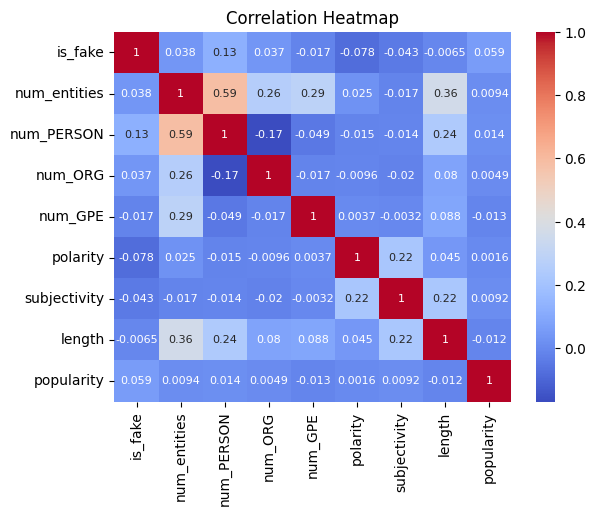

In [13]:
# Plot correlation heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', annot_kws={"size": 8})
plt.title("Correlation Heatmap")
plt.show()


The heatmap shows correlations between features, indicating that "is_fake" has a weak correlation with all features, with the highest being with "num_PERSON" (0.13), while "num_entities" strongly correlates with "num_PERSON" (0.59), suggesting minimal direct predictors for fakeness.

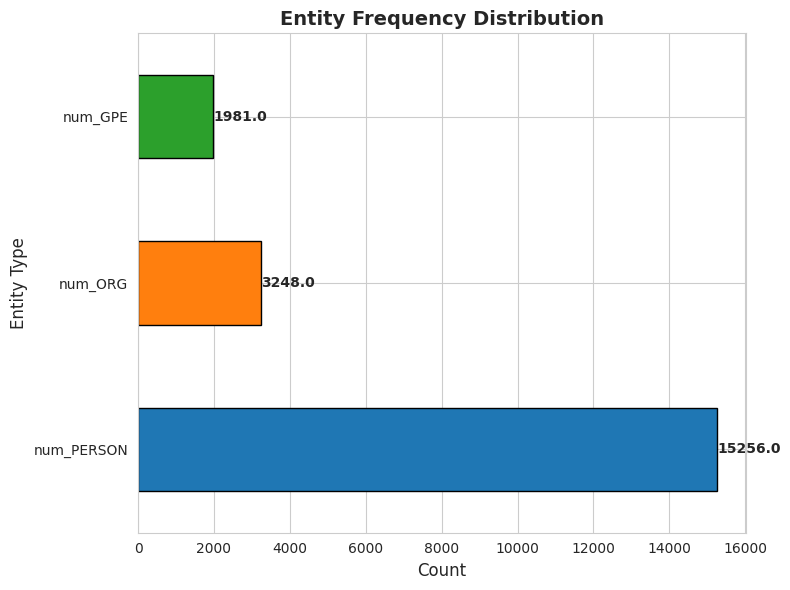

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define entity columns and calculate their counts
entity_cols = ['num_PERSON', 'num_ORG', 'num_GPE']
entity_counts = data[entity_cols].sum()

# Create a horizontal bar chart
sns.set_style("whitegrid")
entity_counts.plot(
    kind='barh',
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],
    edgecolor='black',
    figsize=(8, 6)
)

# Add chart title and axis labels
plt.title("Entity Frequency Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Count", fontsize=12)
plt.ylabel("Entity Type", fontsize=12)

# Annotate the counts on the bars
for index, value in enumerate(entity_counts):
    plt.text(value + 0.5, index, str(value), va='center', fontsize=10, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


The graph shows the frequency of entity types in the dataset, with num_PERSON being the most mentioned, followed by num_ORG and num_GPE.

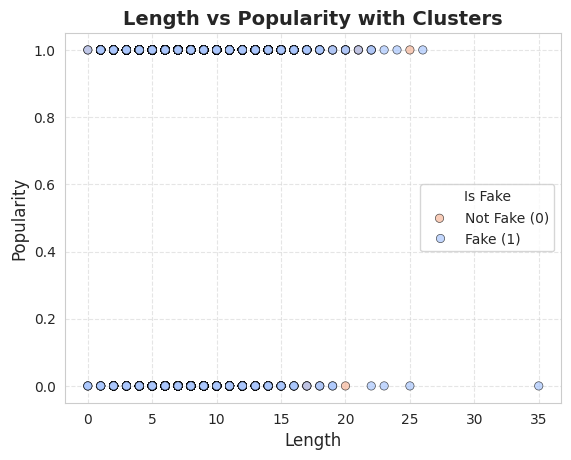

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot to show correlation between length and popularity
sns.scatterplot(
    data=data,
    x="length",
    y="popularity",
    hue="is_fake",  # Clustering based on the 'is_fake' variable
    palette="coolwarm",
    alpha=0.7,
    edgecolor="black"
)

# Add titles and labels
plt.title("Length vs Popularity with Clusters", fontsize=14, fontweight='bold')
plt.xlabel("Length", fontsize=12)
plt.ylabel("Popularity", fontsize=12)
plt.legend(title='Is Fake', labels=['Not Fake (0)', 'Fake (1)'])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


The graph shows that both fake and real data are uniformly distributed in terms of popularity, regardless of length, with minimal clustering differentiation.

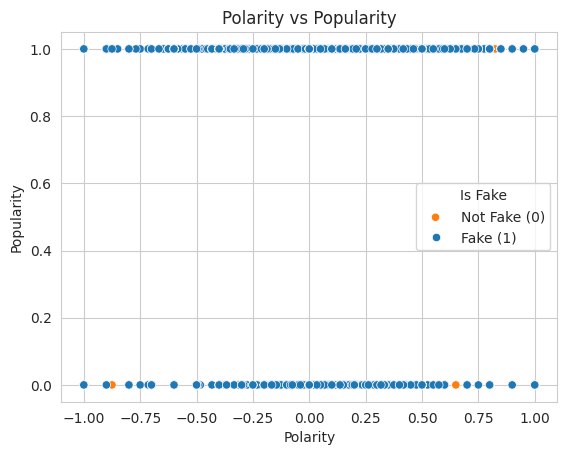

In [16]:
# Scatter plot of polarity vs popularity
sns.scatterplot(x='polarity', y='popularity', hue='is_fake', data=data)
plt.title("Polarity vs Popularity")
plt.xlabel("Polarity")
plt.ylabel("Popularity")
plt.legend(title='Is Fake', labels=['Not Fake (0)', 'Fake (1)'])
plt.show()

The graph shows the relationship between sentiment polarity and popularity, highlighting that fake items (orange) are sparse and scattered, with no clear separation from non-fake items (blue).

In [17]:
# Prepare data for predictive modeling
X = data[['num_entities', 'num_PERSON', 'num_ORG', 'num_GPE', 'polarity', 'subjectivity', 'length', 'is_fake']]
y = data['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [18]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Make predictions on the test set
logistic_pred = log_reg.predict(X_test)

# Display actual and predicted values for the first 10 entries
print("Actual values and Predicted values:")
for actual, predicted in zip(y_test[:10], logistic_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual values and Predicted values:
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1


In [20]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, logistic_pred)

# Print the result
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.06443965517241379


Random Forest Regression

In [21]:
# Train a predictive model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [24]:
# Evaluate the model
rf_pred = model.predict(X_test)
mse = mean_squared_error(y_test, rf_pred)  # Compute Mean Squared Error
rmse = mse ** 0.5  # Take square root to get RMSE
r2 = r2_score(y_test, rf_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")


RMSE: 0.25837994364255634
R2 Score: -0.10736957040237738


In [28]:
#Accuracy for Logistic Regression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Calculate accuracy and F1 score
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_f1 = f1_score(y_test, logistic_pred, zero_division=1)  # Set zero_division=1 to avoid the warning

# Print Logistic Regression performance
print("\nLogistic Regression Performance:")
print(f"Accuracy: {logistic_accuracy:.4f}")
print(f"F1 Score: {logistic_f1:.4f}")
print(classification_report(y_test, logistic_pred, zero_division=1))  # Avoid warnings in classification report


Logistic Regression Performance:
Accuracy: 0.9356
F1 Score: 0.9667
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       299
           1       0.94      1.00      0.97      4341

    accuracy                           0.94      4640
   macro avg       0.97      0.50      0.48      4640
weighted avg       0.94      0.94      0.90      4640



In [27]:
# Accuracy for Random Forest Regression
from sklearn.ensemble import RandomForestClassifier

# Calculate metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print("\nRandom Forest Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(classification_report(y_test, rf_pred))


Random Forest Performance:
Accuracy: 0.9304
F1 Score: 0.9639
              precision    recall  f1-score   support

           0       0.04      0.00      0.01       299
           1       0.94      0.99      0.96      4341

    accuracy                           0.93      4640
   macro avg       0.49      0.50      0.49      4640
weighted avg       0.88      0.93      0.90      4640

